In [1]:
import cartopy

import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


import seaborn as sns

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit, minimize

%matplotlib inline

plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
# Relative path from the notebooks directory to the raw data directory
relative_path = '../data/raw/'

# Read the CSV file extracted from NDIC
wellhead_df = pd.read_csv(relative_path+'ndic_wellheader_data.csv')
production_df = pd.read_csv(relative_path+'ndic_production_data.csv')

# Display the first few rows to confirm
print(wellhead_df.head())
print(production_df.head())

   NDIC File No              API No Well Type Well Status Status Date  \
0         22997  33-025-01733-00-00        OG          PA  11/11/2015   
1         16395  33-025-00603-00-00        OG           A   5/24/2007   
2         22077  33-025-01566-00-00        OG           A    7/7/2012   
3         24697  33-025-02029-00-00        OG           A   3/15/2019   
4         24652  33-025-02022-00-00        OG           A   3/15/2018   

  Wellbore type        Location          Footages   Latitude   Longitude  ...  \
0    Horizontal  NENW 15-141-94  350 FNL 1980 FWL  47.038191 -102.580858  ...   
1    Horizontal   LOT4 3-141-96   342 FNL 269 FWL  47.066724 -102.841014  ...   
2    Horizontal   LOT2 5-142-95  350 FNL 2080 FEL  47.153715 -102.744856  ...   
3    Horizontal   LOT4 6-142-95   370 FNL 660 FWL  47.153394 -102.775846  ...   
4    Horizontal   SESW 7-142-95  300 FSL 2231 FWL  47.126353 -102.769706  ...   

         Comp   Cum Oil  Cum MCF Gas Cum Water IP Oil IP MCF IP Water Spac

In [3]:
# Will be nice to enhance this table with completion data such as proppant and fluid amounts
wellhead_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   NDIC File No             397 non-null    int64  
 1   API No                   397 non-null    object 
 2   Well Type                397 non-null    object 
 3   Well Status              397 non-null    object 
 4   Status Date              397 non-null    object 
 5   Wellbore type            397 non-null    object 
 6   Location                 397 non-null    object 
 7   Footages                 397 non-null    object 
 8   Latitude                 397 non-null    float64
 9   Longitude                397 non-null    float64
 10  Current Operator         397 non-null    object 
 11  Current Well Name        397 non-null    object 
 12  Total Depth              364 non-null    float64
 13  Field                    397 non-null    object 
 14  Pool                     3

In [4]:
# Check Data Types
production_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44185 entries, 0 to 44184
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   File Number  44185 non-null  int64 
 1   Pool         44185 non-null  object
 2   Date         44185 non-null  object
 3   Days         44185 non-null  int64 
 4   BBLS Oil     44185 non-null  int64 
 5   Runs         44185 non-null  int64 
 6   BBLS Water   44185 non-null  int64 
 7   MCF Prod     44185 non-null  int64 
 8   MCF Sold     44185 non-null  int64 
 9   Vent/Flare   44185 non-null  int64 
dtypes: int64(8), object(2)
memory usage: 3.4+ MB


In [5]:
# Format Date object to date time
production_df['Date'] = pd.to_datetime(production_df['Date'], format='%m-%Y')

In [6]:
production_df.head()

File Number    Pool       Date  Days  BBLS Oil  Runs  BBLS Water  MCF Prod  \
0        16395  BAKKEN 2024-10-01    31       224   240         675       265   
1        16395  BAKKEN 2024-09-01    30       211   236         640       263   
2        16395  BAKKEN 2024-08-01    31       216   245         665       285   
3        16395  BAKKEN 2024-07-01    31       207   224         641       290   
4        16395  BAKKEN 2024-06-01    30       220   244         667       300   

   MCF Sold  Vent/Flare  
0        11           0  
1        17           0  
2        31           0  
3        40           0  
4        54           0

In [7]:
# Let's see where these wells are located

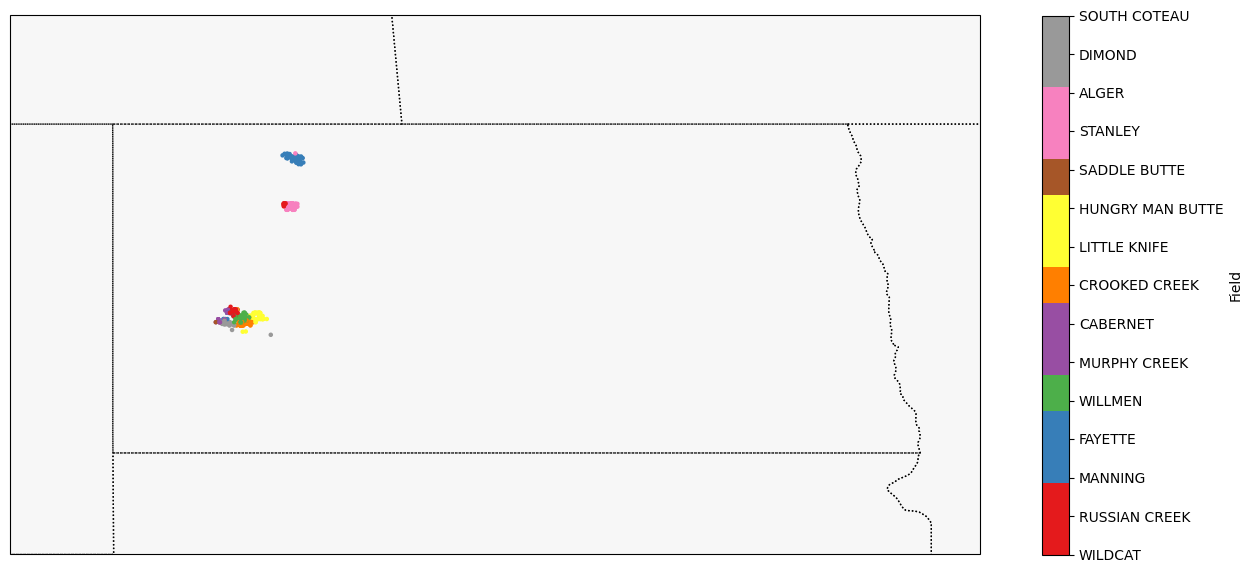

In [8]:
fig = plt.figure(figsize=[16, 7])
ax = fig.add_subplot(1, 1, 1, projection=cartopy.crs.PlateCarree())
ax.set_extent([-105, -96, 45, 50], crs=cartopy.crs.PlateCarree())
ax.set_extent([-105, -96, 45, 50], crs=cartopy.crs.PlateCarree())

# Get unique 'Fields'
unique_fields = wellhead_df['Field'].unique()
# Define colors for each unique field
colors = plt.cm.Set1(np.linspace(0, 1, len(unique_fields)))
cmap = ListedColormap(colors)

# Map categories to numbers for color mapping
categories = wellhead_df['Field'].astype('category').cat.codes

art = ax.scatter(
    wellhead_df.Longitude, 
    wellhead_df.Latitude, 
    c=categories, 
    cmap=cmap,
    s=5
)

# Create a custom colorbar
cbar = fig.colorbar(art, ticks=range(len(unique_fields)))
cbar.ax.set_yticklabels(unique_fields)
cbar.set_label('Field')

ax.add_feature(cartopy.feature.LAND, color=[0.97, 0.97, 0.97])
ax.add_feature(cartopy.feature.STATES, linestyle=':')

plt.show()

In [9]:
fig = plt.figure(figsize=[16, 8])
ax = fig.add_subplot(1, 1, 1)
for _, chunk in production_df.groupby('File Number'):
    ax.plot(chunk['Date'], chunk['BBLS Oil']/30.4167, alpha=0.05, color='C0')
ax.set_yscale('log')
ax.set_facecolor((0.97, 0.97, 0.97))
ax.set_ylabel('Avg daily rate')
ax.set_xlabel('Date')
ax.grid(color='w')

In [10]:
# Let's normalize to calculate producing days
# Step 1: Group by 'File Number' and find the minimum date for each group
min_dates = production_df.groupby('File Number')['Date'].transform('min')

# Step 2: Calculate the difference in days
production_df['producing_days'] = (production_df['Date'] - min_dates).dt.days

# Step 3: Round the producing_days to the nearest 30-day increment
production_df['producing_days'] = (production_df['producing_days'] / 30).round() * 30

In [11]:
#Let's add the daily rate column to production df
production_df['daily_oil_rate'] = production_df['BBLS Oil']/production_df['Days']
production_df['daily_gas_rate'] = production_df['MCF Prod']/production_df['Days']
production_df['daily_water_rate'] = production_df['BBLS Water']/production_df['Days']
# Sort by file number and days
production_df = production_df.sort_values(by=['File Number','producing_days'], ascending = [True,True])

In [12]:
fig = plt.figure(figsize=[16, 8])
ax = fig.add_subplot(1, 1, 1)
for _, chunk in production_df.groupby('File Number'):
    ax.plot(chunk['producing_days'], chunk['daily_oil_rate'], alpha=0.1, color='C0')
# Add Average line (proxy for type curve)
ax.plot(production_df.groupby('producing_days')['daily_oil_rate'].mean(), alpha=0.5, color='black', linewidth=3)
ax.set_yscale('log')
ax.set_facecolor((0.97, 0.97, 0.97))
ax.set_ylabel('daily production rate (bopd)')
ax.set_xlabel('Days')
ax.grid(color='w')

### Let's create some additional columns like cumulative production volumes, smoothing averages, production outlier detection 

In [13]:
# adding Cumulative Volumes to production df
production_df['Cumulative_Oil_BBLS'] = production_df.groupby('File Number')['BBLS Oil'].cumsum()
production_df['Cumulative_Gas_MCF'] = production_df.groupby('File Number')['MCF Prod'].cumsum()
production_df['Cumulative_Wtr_BBLS'] = production_df.groupby('File Number')['BBLS Water'].cumsum()

# Calculate rolling mean and standard deviations
# Let's set a rolling window of 2 months
window = 12
production_df['rolling_oil_mean'] = (
    production_df.groupby('File Number')['daily_oil_rate']
    .rolling(window=window, center=True)
    .mean()
    .reset_index(level=0, drop=True)  # Align the index with the original DataFrame
)

production_df['rolling_oil_std'] = (
    production_df.groupby('File Number')['daily_oil_rate']
    .rolling(window=window, center=True)
    .std()
    .reset_index(level=0, drop=True)  # Align the index with the original DataFrame
)
# can do this for gas and water as welll, but will focus on oil for now

### Function: `plot_actual_vs_smoothed_dailyOil_per_well`
This function visualizes the actual daily oil production rate against the smoothed (rolling mean) production rate for a specified well. 

**Parameters**:
- `well_file` (int): The unique file number of the well to visualize.

**Plot Details**:
- `producing_days`: The x-axis represents the number of producing days since the start.
- `daily_oil_rate`: The actual daily oil production rate is shown as a solid green line.
- `rolling_oil_mean`: The smoothed production rate is shown as a dashed red line.


In [14]:
def plot_actual_vs_smoothed_dailyOil_per_well(well_file):
    # Filter data for the selected well
    actual_data = production_df[production_df['File Number'] == well_file]    
    
    # Ensure data is sorted by time if not already
    actual_data = actual_data.sort_values('producing_days')
    
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(actual_data['producing_days'], actual_data['daily_oil_rate'], label='Actual', marker='o', linestyle='-', color='green')
    plt.plot(actual_data['producing_days'], actual_data['rolling_oil_mean'], label='Smoothed', marker='x', linestyle='--', color='red')

    plt.title(f'Production for Well {well_file}')
    plt.xlabel('Days')
    plt.ylabel('Production')
    plt.legend()
    plt.grid(True)
    plt.show()

### Function: `plot_actual_CumulativeOil_per_well`
This function visualizes the cumulative oil production over time for a specified well.

**Parameters**:
- `well_file` (int): The unique file number of the well to visualize.

**Plot Details**:
- `producing_days`: The x-axis represents the number of producing days since the start.
- `Cumulative_Oil_BBLS`: The cumulative oil production is shown as a solid green line.


In [15]:
def plot_actual_CumulativeOil_per_well(well_file):
    # Filter data for the selected well
    actual_data = production_df[production_df['File Number'] == well_file]    
    
    # Ensure data is sorted by time if not already
    actual_data = actual_data.sort_values('producing_days')
    
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(actual_data['producing_days'], actual_data['Cumulative_Oil_BBLS'], label='Actual', marker='o', linestyle='-', color='green')
   

    plt.title(f'Production for Well {well_file}')
    plt.xlabel('Days')
    plt.ylabel('Cumulative Production')
    plt.legend()
    plt.grid(True)
    plt.show()

In [16]:
# well_list contains a list of unique well identifiers
well_list = sorted(production_df['File Number'].unique())

# Create a dropdown for well selection
dropdown = widgets.Dropdown(options=well_list, description='Select Well:')

# Create an interactive widget
interactive_plot = widgets.interactive(plot_actual_vs_smoothed_dailyOil_per_well, well_file=dropdown)
interactive_cum_plot = widgets.interactive(plot_actual_CumulativeOil_per_well, well_file=dropdown)

# Display the interactive plot
display(interactive_plot)
display(interactive_cum_plot)

interactive(children=(Dropdown(description='Select Well:', options=(np.int64(10450), np.int64(12840), np.int64…

interactive(children=(Dropdown(description='Select Well:', options=(np.int64(10450), np.int64(12840), np.int64…

In [17]:
# Let's create a function to mark outliers based on whether or not a production point falls within a moving acceptable standard deviation
def mark_outliers(df, column_name, std_acceptable_window=3):
    """
    Marks outliers based on whether a value falls outside the acceptable range 
    defined by a rolling mean and standard deviation.
    
    Parameters:
    df (DataFrame): The DataFrame containing the data.
    column_name (str): The name of the column to check for outliers.
    std_acceptable_window (float): Number of acceptable standard deviations 
                                    for defining the outlier range.
    
    Returns:
    Series: A Boolean Series where True indicates an outlier.
    """
    df = df.copy()
    # Avoid division by zero
    rolling_std = df['rolling_oil_std'].replace(0, 1e-10)
    
    # Define bounds
    upper_bound = df['rolling_oil_mean'] + std_acceptable_window * rolling_std
    lower_bound = df['rolling_oil_mean'] - std_acceptable_window * rolling_std
    
    # Calculate outliers
    is_outlier = (df[column_name] > upper_bound) | (df[column_name] < lower_bound)
    
    return is_outlier


In [19]:
# Apply function to determine potential points of production outside of acceptable range
production_df['is_outlier'] = mark_outliers(production_df, 'daily_oil_rate', std_acceptable_window=3)


### Function: `plot_actual_vs_smoothed_w_outliers`
This function visualizes the actual daily oil production rate against the smoothed (rolling mean) production rate for a specified well, with optional zooming and outlier highlighting.

**Parameters**:
- `well_file` (int): The unique file number of the well to visualize.
- `std_acceptable_window` (float): The acceptable range (in terms of standard deviations) for flagging outliers.
- `zoom_start` (int or None): The starting point of the zoom window in terms of producing days. If `None`, no zooming is applied.
- `zoom_end` (int or None): The ending point of the zoom window in terms of producing days. If `None`, no zooming is applied.

**Plot Details**:
- `producing_days`: The x-axis represents the number of producing days since the start.
- `daily_oil_rate`: The actual daily oil production rate is shown as a solid green line.
- `rolling_oil_mean`: The smoothed production rate is shown as a dashed red line.
- **Outliers**: Highlighted as blue diamonds based on the standard deviation threshold.
- **Bounds**:
  - Orange dashed line: Upper acceptable bound.
  - Purple dashed line: Lower acceptable bound.
  
**Features**:
- Custom zooming: Allows focusing on specific ranges of producing days.
- Outlier detection: Highlights points that exceed the acceptable standard deviation window.
- Dynamic bounds: Draws horizontal lines indicating the upper and lower bounds based on the smoothed mean and standard deviation.


In [20]:
def plot_actual_vs_smoothed_w_outliers(well_file, std_acceptable_window, zoom_start, zoom_end):
    # Filter data for the selected well
    well_data = production_df[production_df['File Number'] == well_file]

    # Ensure data is sorted by producing_days
    well_data = well_data.sort_values('producing_days')

    # Apply zoom window
    if zoom_start is not None and zoom_end is not None:
        well_data = well_data[
            (well_data['producing_days'] >= zoom_start) &
            (well_data['producing_days'] <= zoom_end)
        ]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(
        well_data['producing_days'],
        well_data['daily_oil_rate'],
        label='Actual',
        marker='o',
        linestyle='-',
        color='green'
    )
    plt.plot(
        well_data['producing_days'],
        well_data['rolling_oil_mean'],
        label='Smoothed',
        marker='x',
        linestyle='--',
        color='red'
    )

    # Highlight outliers
    outliers = well_data[well_data['is_outlier']]
    plt.scatter(
        outliers['producing_days'],
        outliers['daily_oil_rate'],
        color='blue',
        s=100,
        label='Outliers',
        marker='D'
    )

    # Horizontal lines for std_acceptable_window
    if not well_data.empty:
        upper_bound = well_data['rolling_oil_mean'] + std_acceptable_window * well_data['rolling_oil_std']
        lower_bound = well_data['rolling_oil_mean'] - std_acceptable_window * well_data['rolling_oil_std']
        plt.axhline(upper_bound.iloc[0], color='orange', linestyle='--', label='Upper Bound')
        plt.axhline(lower_bound.iloc[0], color='purple', linestyle='--', label='Lower Bound')

    plt.title(f'Production for Well {well_file}')
    plt.xlabel('Producing Days')
    plt.ylabel('Daily Oil Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

In [22]:
# Widgets
well_list =  sorted(production_df[production_df['is_outlier']==True]['File Number'].unique())

# Create a dropdown for well selection
dropdown = widgets.Dropdown(options=well_list, description='Select Well:')

std_slider = widgets.FloatSlider(
    value=2.0, min=0.5, max=5.0, step=0.5,
    description='Std Dev Window:'
)
zoom_start = widgets.IntText(
    value=0, description='Zoom Start:',
    step=10
)
zoom_end = widgets.IntText(
    value=5000, description='Zoom End:',
    step=10
)

# Link widgets to plot function
interactive_plot = widgets.interactive(
    plot_actual_vs_smoothed_w_outliers,
     well_file=dropdown,
    std_acceptable_window=std_slider,
    zoom_start=zoom_start,
    zoom_end=zoom_end
)

# Display
display(interactive_plot)

interactive(children=(Dropdown(description='Select Well:', options=(np.int64(12840), np.int64(15824), np.int64…

In [23]:
#TODO Will need to determine what to do with outliers later when forecasting

In [25]:
# Can we use prophet's confidence to potentially highlight outliers
from prophet import Prophet

In [26]:
prophet_df = production_df.copy()

In [27]:
prophet_df.columns

Index(['File Number', 'Pool', 'Date', 'Days', 'BBLS Oil', 'Runs', 'BBLS Water',
       'MCF Prod', 'MCF Sold', 'Vent/Flare', 'producing_days',
       'daily_oil_rate', 'daily_gas_rate', 'daily_water_rate',
       'Cumulative_Oil_BBLS', 'Cumulative_Gas_MCF', 'Cumulative_Wtr_BBLS',
       'rolling_oil_mean', 'rolling_oil_std', 'is_outlier'],
      dtype='object')

In [37]:
prophet_cols = ['File Number',  'Date', 'BBLS Water',      
       'daily_oil_rate', 'is_outlier']
prophet_df = prophet_df[prophet_cols]
prophet_df

File Number       Date  BBLS Water  daily_oil_rate  is_outlier
28773        10450 2019-07-01           0             NaN       False
28772        10450 2019-08-01           0             NaN       False
17690        12840 1990-11-01           0           154.0       False
17689        12840 1990-12-01           0             NaN       False
17688        12840 1991-01-01           0            67.5       False
...            ...        ...         ...             ...         ...
43843        90191 2016-11-01           0             0.0       False
43842        90191 2016-12-01           0             NaN       False
43841        90191 2017-01-01           0             NaN       False
11680        90221 2019-07-01           0             NaN       False
11679        90221 2019-08-01           0             NaN       False

[44185 rows x 5 columns]

In [85]:
# Initialize dictionaries to store models, forecasts, and errors
models = {}
forecasts = {}
errors = {}

# Loop through each well
for file in prophet_df['File Number'].unique():
    # Drop rows where any required data is NaN
    required_columns = ['ds', 'y', 'BBLS Water']

    well_data = prophet_df[prophet_df['File Number'] == file]    

    # Ensure 'well_data' is not being overwritten after renaming columns
    well_data_prophet = well_data.rename(columns={'Date': 'ds', 'daily_oil_rate': 'y'}).dropna(subset=required_columns)

    try:
        # Initialize and set up the Prophet model 
        model = Prophet(daily_seasonality=False, yearly_seasonality=False, weekly_seasonality=False)
        #model.add_seasonality(name='monthly', period=30.5, fourier_order=7)
        

        # Fit the model
        model.fit(well_data_prophet)

        # Store the fitted model
        models[file] = model

        # Create future dataframe for forecasting
        future = model.make_future_dataframe(periods=6, freq='ME')

        # Merge the future dataframe with known future values of the regressors
        future_merged = future.merge(well_data_prophet[['ds', 'y', 'BBLS Water', 'is_outlier']], on='ds', how='left')

        # Make the forecast
        forecast = model.predict(future_merged)

        # Store the forecast
        forecasts[file] = forecast

    except Exception as e:
        # Store and print error information
        errors[file] = str(e)
        print(f"Could not model well {file} due to error: {e}")

16:26:07 - cmdstanpy - INFO - Chain [1] start processing
16:26:07 - cmdstanpy - INFO - Chain [1] done processing


Could not model well 10450 due to error: Dataframe has less than 2 non-NaN rows.
Could not model well 12840 due to error: Found infinity in column y.


16:26:07 - cmdstanpy - INFO - Chain [1] start processing
16:26:07 - cmdstanpy - INFO - Chain [1] done processing


Could not model well 15989 due to error: Found infinity in column y.
Could not model well 16031 due to error: Found infinity in column y.


16:26:08 - cmdstanpy - INFO - Chain [1] start processing
16:26:08 - cmdstanpy - INFO - Chain [1] done processing
16:26:08 - cmdstanpy - INFO - Chain [1] start processing
16:26:08 - cmdstanpy - INFO - Chain [1] done processing
16:26:08 - cmdstanpy - INFO - Chain [1] start processing
16:26:08 - cmdstanpy - INFO - Chain [1] done processing


Could not model well 16229 due to error: Found infinity in column y.


16:26:08 - cmdstanpy - INFO - Chain [1] start processing
16:26:08 - cmdstanpy - INFO - Chain [1] done processing
16:26:08 - cmdstanpy - INFO - Chain [1] start processing
16:26:08 - cmdstanpy - INFO - Chain [1] done processing
16:26:08 - cmdstanpy - INFO - Chain [1] start processing
16:26:08 - cmdstanpy - INFO - Chain [1] done processing
16:26:09 - cmdstanpy - INFO - Chain [1] start processing
16:26:09 - cmdstanpy - INFO - Chain [1] done processing
16:26:09 - cmdstanpy - INFO - Chain [1] start processing
16:26:09 - cmdstanpy - INFO - Chain [1] done processing
16:26:09 - cmdstanpy - INFO - Chain [1] start processing
16:26:09 - cmdstanpy - INFO - Chain [1] done processing
16:26:09 - cmdstanpy - INFO - Chain [1] start processing
16:26:09 - cmdstanpy - INFO - Chain [1] done processing
16:26:09 - cmdstanpy - INFO - Chain [1] start processing
16:26:09 - cmdstanpy - INFO - Chain [1] done processing
16:26:09 - cmdstanpy - INFO - Chain [1] start processing
16:26:09 - cmdstanpy - INFO - Chain [1]

Could not model well 22236 due to error: Dataframe has less than 2 non-NaN rows.


16:26:28 - cmdstanpy - INFO - Chain [1] done processing
16:26:28 - cmdstanpy - INFO - Chain [1] start processing
16:26:28 - cmdstanpy - INFO - Chain [1] done processing
16:26:28 - cmdstanpy - INFO - Chain [1] start processing
16:26:28 - cmdstanpy - INFO - Chain [1] done processing
16:26:28 - cmdstanpy - INFO - Chain [1] start processing
16:26:28 - cmdstanpy - INFO - Chain [1] done processing
16:26:29 - cmdstanpy - INFO - Chain [1] start processing
16:26:29 - cmdstanpy - INFO - Chain [1] done processing
16:26:29 - cmdstanpy - INFO - Chain [1] start processing
16:26:29 - cmdstanpy - INFO - Chain [1] done processing
16:26:29 - cmdstanpy - INFO - Chain [1] start processing
16:26:29 - cmdstanpy - INFO - Chain [1] done processing
16:26:29 - cmdstanpy - INFO - Chain [1] start processing
16:26:29 - cmdstanpy - INFO - Chain [1] done processing
16:26:29 - cmdstanpy - INFO - Chain [1] start processing
16:26:29 - cmdstanpy - INFO - Chain [1] done processing
16:26:29 - cmdstanpy - INFO - Chain [1] 

Could not model well 90174 due to error: Dataframe has less than 2 non-NaN rows.
Could not model well 90221 due to error: Dataframe has less than 2 non-NaN rows.


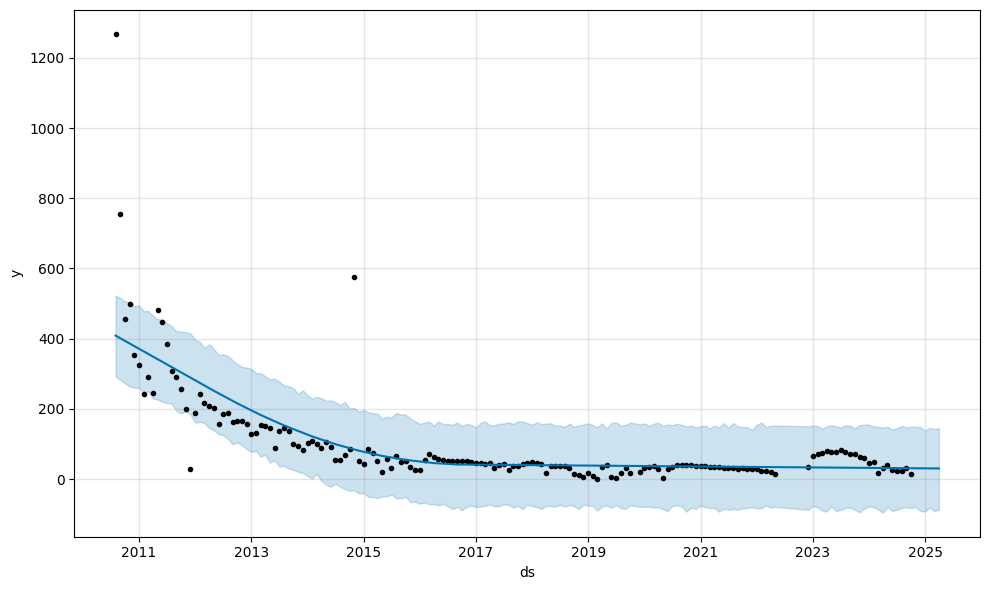

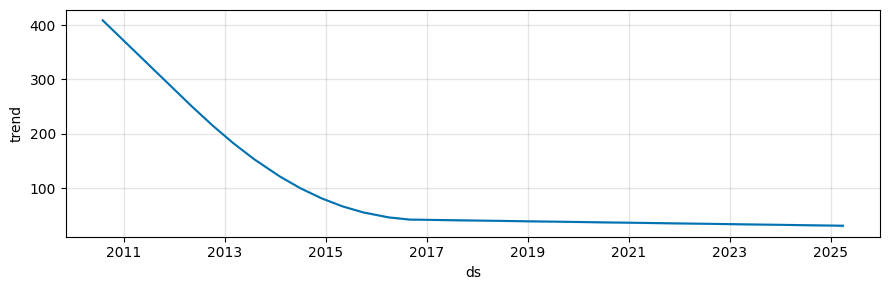

In [86]:
# Access the model for a specific well
specific_well_id = 18406
specific_model = models[specific_well_id]

# Access the forecast for the same well
specific_forecast = forecasts[specific_well_id]

# Plotting the forecast
fig = specific_model.plot(specific_forecast)
fig2 = specific_model.plot_components(specific_forecast)

In [89]:
forecasts_df = pd.concat([df.assign(well_id=key) for key, df in forecasts.items()], ignore_index=True)
forecasts_df.head()

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2005-08-01  178.864406  159.109923  201.162122   178.864406   178.864406   
1 2005-09-01  173.603056  152.141034  195.655036   173.603056   173.603056   
2 2005-10-01  168.511428  148.091114  191.933009   168.511428   168.511428   
3 2005-11-01  163.250078  141.196675  185.021824   163.250078   163.250078   
4 2005-12-01  158.158450  136.490888  180.022087   158.158450   158.158450   

   additive_terms  additive_terms_lower  additive_terms_upper  \
0             0.0                   0.0                   0.0   
1             0.0                   0.0                   0.0   
2             0.0                   0.0                   0.0   
3             0.0                   0.0                   0.0   
4             0.0                   0.0                   0.0   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper        yhat  well_id  
0                         0.0  178.864406    15824  
1                         0.0  173.603056    15824  
2                         0.0  168.511428    15824  
3                         0.0  163.250078    15824  
4                         0.0  158.158450    15824

In [93]:
# Rename columns to match Prophet's expected format
actual_data = production_df.rename(columns={'Date': 'ds', 'File Number': 'well_id' ,'daily_oil_rate': 'y'})

# Merge actual data with forecast
merged = pd.merge(actual_data,forecasts_df[['well_id','ds','trend' ,'yhat', 'yhat_lower', 'yhat_upper']], on=['ds', 'well_id'], how ='outer')


In [94]:
def plot_forecast_with_outliers(forecasts, well_id):
    """
    Plot Prophet forecast with actual data and highlight outliers.

    Parameters:
    - model: The fitted Prophet model.
    - forecast: The forecast dataframe from the model.
    - actual_data: The actual production data (as a dataframe with columns `date` and `daily_oil_rate`).
    """
    # Filter the data for the specific well_id
    well_data = merged[merged['well_id'] == well_id]    
    
    # Plot the actual vs forecasted values
    plt.figure(figsize=(12, 6))
    plt.plot(well_data['producing_days'], well_data['y'], label='Actual Daily Oil Rate', color='green', marker='o', linestyle='-')
    plt.plot(well_data['producing_days'], well_data['yhat'], label='Forecasted Daily Oil Rate', color='blue', linestyle='--')
    plt.fill_between(
        well_data['producing_days'],
        well_data['yhat_lower'],
        well_data['yhat_upper'],
        color='blue',
        alpha=0.2,
        label='Forecast Confidence Interval'
    )
    
    # Highlight outliers
    # Ensure 'is_outlier' column has no NaN values
    # Ensure 'is_outlier' column has no NaN values
    well_data.loc[:, 'is_outlier'] = well_data['is_outlier'].fillna(False).infer_objects(copy=False)
    outliers = well_data[well_data['is_outlier']]

    plt.scatter(outliers['producing_days'], outliers['y'], color='red', s=150, label='Outliers', marker='x', linewidth=2)
    
    # Add titles and labels
    plt.title('Actual vs Forecasted Daily Oil Rate for Well 18406')
    plt.xlabel('Days')
    plt.ylabel('Daily Oil Rate')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    
    # Show the plot
    plt.show()

In [95]:
# Example usage:
pd.set_option('future.no_silent_downcasting', True)
well_id = 18406 # Replace with the desired well ID

plot_forecast_with_outliers(merged, well_id)

In [ ]:
# Calculate correlation matrix
corr_matrix = production_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

# Specifically look at correlations with 'novi_oil'
print(corr_matrix['novi_oil'].sort_values(ascending=False))